# 빅데이터와 금융자료분석 팀프로젝트

XGboost 알고리즘을 활용한 은행 대출의 부도 여부 예측 모델 구축

강상묵(20259013) / 김형환(20249132) / 유석호(20249264) / 이현준(20249349) / 최영서(20249430) / 최재필(20249433)

코드 추가

In [1]:
# 모든 난수 생성에 일관된 시드 설정 - 재현성 확보
import numpy as np
import random
import os
import pickle

# 모든 난수 생성기에 일관된 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 결과 저장을 위한 디렉토리 생성
os.makedirs('model_results', exist_ok=True)

## 1. 데이터 불러오기 및 데이터 확인 : 12개의 수치형변수와 15개의 문자형 변수(목적변수 포함)

In [2]:
# 1. 데이터 불러오기 및 데이터 확인 : 12개의 수치형변수와 15개의 문자형 변수(목적변수 포함)
import pandas as pd
data = pd.read_csv("data/lending_club_loan_two.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

### 1.1 클래스 불균형 및 변수간 상관관계 시각화

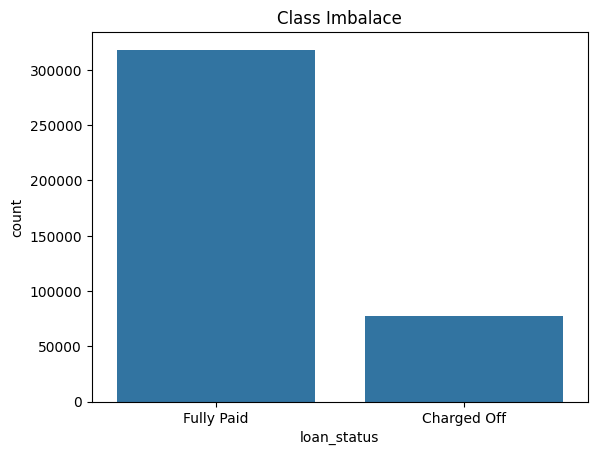

In [3]:
# 클래스 불균형 시각화 : 목적변수는 약 8:2로 불균형 존재
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=data['loan_status'])
plt.title("Class Imbalace")
plt.show()

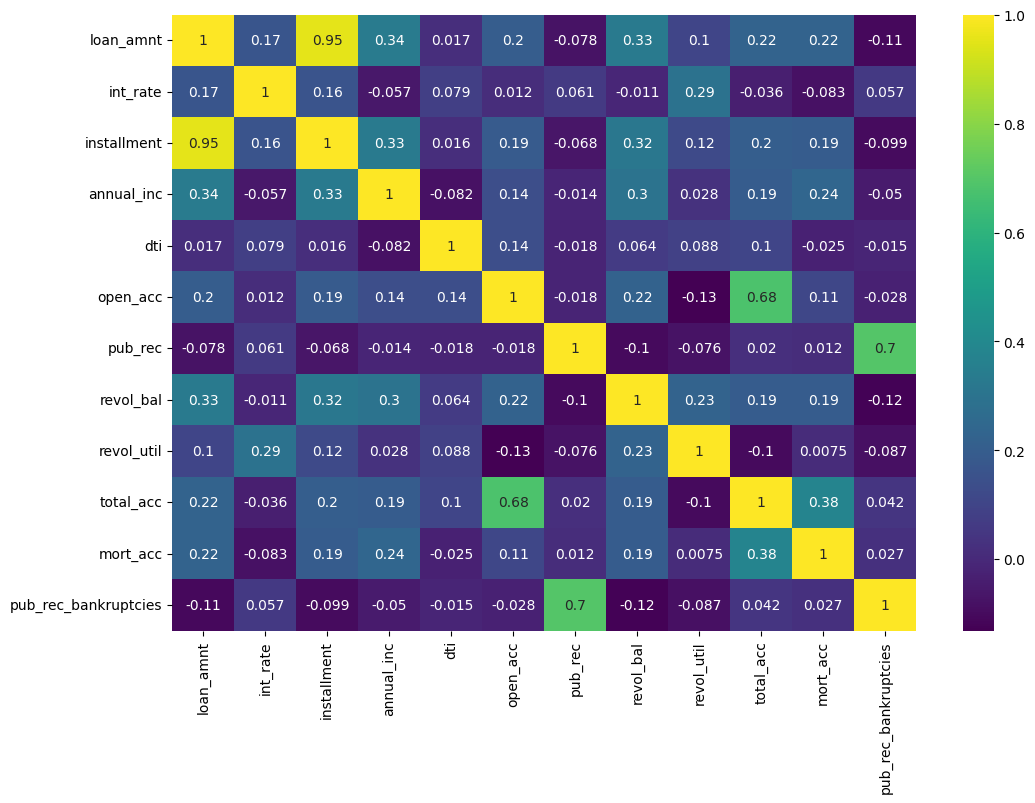

In [4]:
# 수치형 데이터간 상관관계 행렬 그리기 : 일부 변수에 높은 상관관계가 존재하는 것을 확인
plt.figure(figsize=(12, 8))

numeric_data = data.select_dtypes(include=['number'])

sns.heatmap(numeric_data.corr(), annot=True, cmap='viridis')
plt.show()

### 1.2 주요 변수별 목적변수 분포 확인

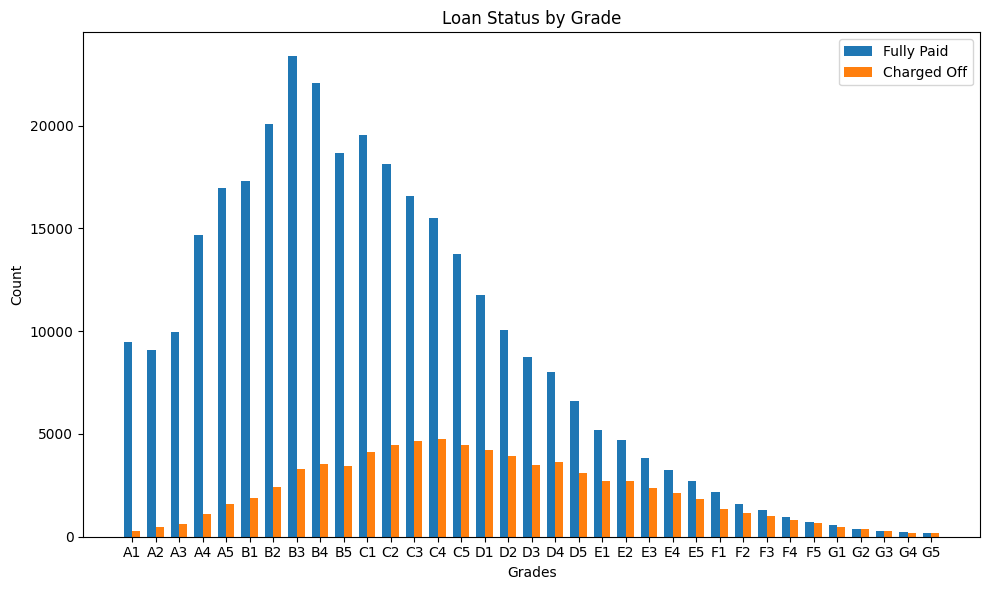

In [5]:
# 신용점수별 목적변수의 분포 확인 : 낮은 등급일수록 부도율 높음
fully_paid = data.loc[data['loan_status'] == 'Fully Paid', 'sub_grade'].value_counts().sort_index()
charged_off = data.loc[data['loan_status'] == 'Charged Off', 'sub_grade'].value_counts().sort_index()

grades = sorted(set(fully_paid.index).union(set(charged_off.index)))

x = range(len(grades))
width = 0.35  # bar 폭

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], fully_paid.reindex(grades, fill_value=0), width=width, label='Fully Paid')
ax.bar([i + width/2 for i in x], charged_off.reindex(grades, fill_value=0), width=width, label='Charged Off')

ax.set_xlabel('Grades')
ax.set_ylabel('Count')
ax.set_title('Loan Status by Grade')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\1229110848.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'vacation'),
 Text(1, 0, 'debt_consolidation'),
 Text(2, 0, 'credit_card'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'other'),
 Text(7, 0, 'medical'),
 Text(8, 0, 'wedding'),
 Text(9, 0, 'car'),
 Text(10, 0, 'moving'),
 Text(11, 0, 'house'),
 Text(12, 0, 'educational'),
 Text(13, 0, 'renewable_energy')]

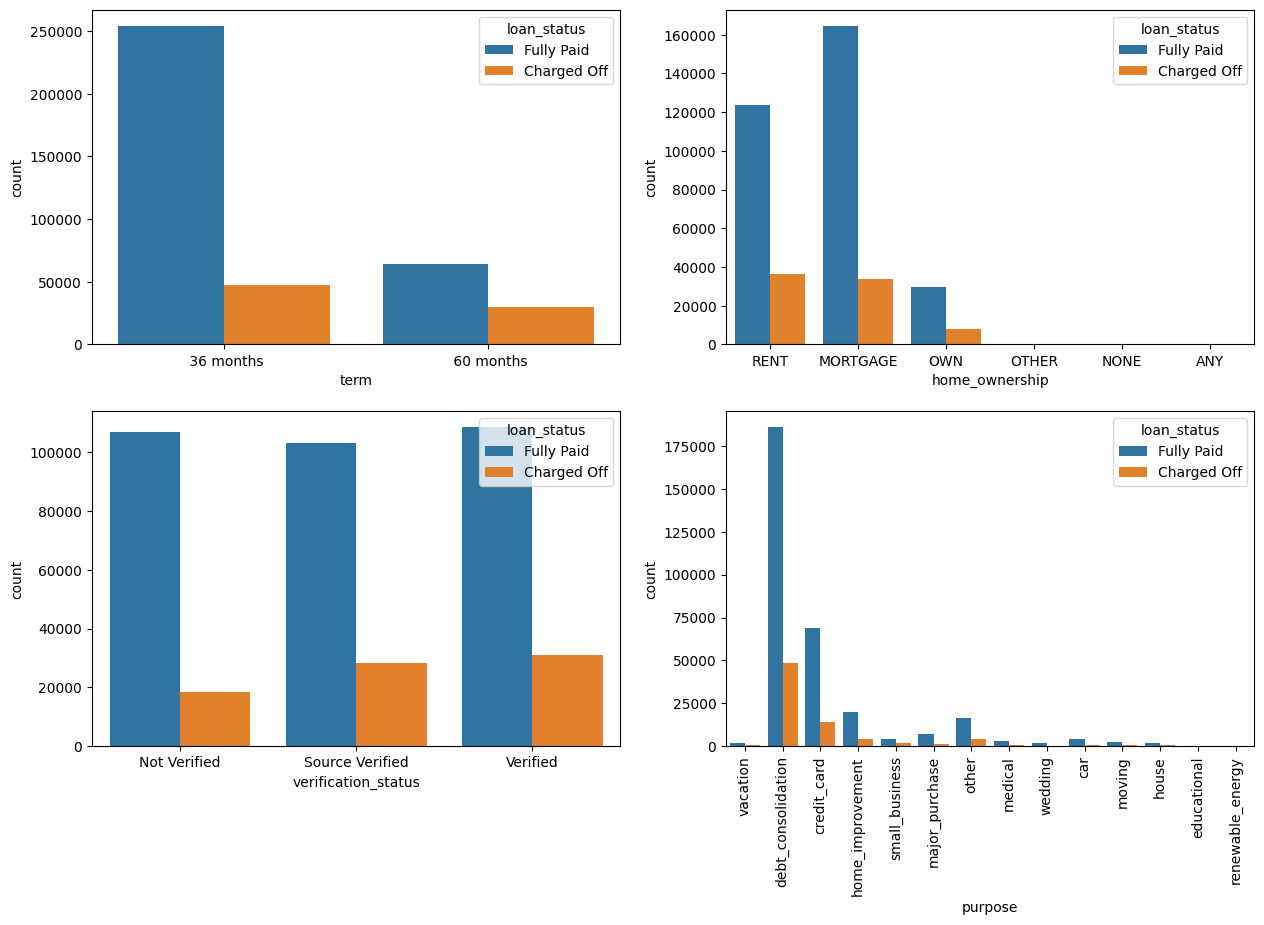

In [6]:
# 대출기간, 집보유여부 등 주요 변수에 대한 목적변수 분포 확인
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [7]:
# 문자형 변수 고유값 개수 출력 : 일부 변수에 과도하게 많은 고유값 확인
categorical_columns = data.select_dtypes(include='object')
categorical_columns.nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              173105
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   115
loan_status                 2
purpose                    14
title                   48816
earliest_cr_line          684
initial_list_status         2
application_type            3
address                393700
dtype: int64

## 2. 데이터 전처리

In [8]:
# 2. 데이터 전처리
# 주소는 우편번호만 추출
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data['zip_code'].nunique()

10

In [9]:
# 집 소유여부에서 극소수의 경우 제외
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  

# 대출건별로 모두 달라 고유값이 너무 많거나(100개 이상), 다른 변수로부터 추출할수있는 등 불필요한 열 제거
drop_cols = ['emp_title', 'emp_length', 'grade', 'title', 'address', 'issue_d', 'earliest_cr_line']
data.drop(columns=drop_cols, inplace=True)

# 대출개월수는 수치형으로 변환
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

# 문자형변수 변환 : 라벨인코딩, 원핫인코딩
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 목적변수 (loan_status) 라벨 인코딩
label_encoder = LabelEncoder()
data['loan_status'] = label_encoder.fit_transform(data['loan_status'])

# sub_grade 라벨 인코딩 : 평가등급은 순서가 있음
data['sub_grade'] = label_encoder.fit_transform(data['sub_grade'])

# 나머지 문자형 변수들 원핫 인코딩
categorical_columns = data.select_dtypes(include='object').columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            396030 non-null  float64
 1   term                                 396030 non-null  int64  
 2   int_rate                             396030 non-null  float64
 3   installment                          396030 non-null  float64
 4   sub_grade                            396030 non-null  int32  
 5   annual_inc                           396030 non-null  float64
 6   loan_status                          396030 non-null  int32  
 7   dti                                  396030 non-null  float64
 8   open_acc                             396030 non-null  float64
 9   pub_rec                              396030 non-null  float64
 10  revol_bal                            396030 non-null  float64
 11  revol_util   

### 2.1 훈련/평가데이터 분할

목적변수의 클래스 불균형이 존재하므로, 훈련/평가데이터 분할 시 **계층적 샘플링(Stratified Sampling)**을 적용합니다.
이는 각 분할 세트에서 클래스 비율이 원본 데이터셋과 동일하게 유지되도록 보장하여, 
특히 소수 클래스(부도)가 테스트 세트에서 과소 또는 과대 표현되지 않도록 합니다.

In [10]:
# 훈련/평가데이터 분할 : 7대3로 분할 (계층적 샘플링 적용)
from sklearn.model_selection import train_test_split

X = data.drop(columns=['loan_status']) 
y = data['loan_status']

# stratify=y 매개변수를 추가하여 계층적 샘플링 적용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 분할 후 클래스 비율 확인
print("원본 데이터 클래스 분포:")
print(y.value_counts(normalize=True))

print("\n훈련 데이터 클래스 분포:")
print(y_train.value_counts(normalize=True))

print("\n테스트 데이터 클래스 분포:")
print(y_test.value_counts(normalize=True))

원본 데이터 클래스 분포:
loan_status
1    0.803871
0    0.196129
Name: proportion, dtype: float64

훈련 데이터 클래스 분포:
loan_status
1    0.803871
0    0.196129
Name: proportion, dtype: float64

테스트 데이터 클래스 분포:
loan_status
1    0.80387
0    0.19613
Name: proportion, dtype: float64


계층적 샘플링을 통해 원본 데이터의 클래스 분포가 훈련 및 테스트 세트에서 동일하게 유지되는 것을 확인할 수 있습니다.
이는 모델이 훈련 중에 편향되지 않도록 하고, 테스트 성능이 실제 성능을 더 정확하게 반영하도록 합니다.

In [11]:
# 3. 결측값 및 이상치 처리 (중간값 + Isolation Forest)
from sklearn.ensemble import IsolationForest

# 수치형 변수의 결측값을 중간값으로 처리
X_train_fillna = X_train.copy().fillna(X_train.median())

X_train_numeric = X_train_fillna.select_dtypes(include='number')
original_len = len(X_train_numeric)

# 이상치 탐지 및 제거 (수치형 변수에 대해서만 1% 제거)
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(X_train_numeric)

# 이상치가 아닌 데이터만 선택
X_train_clean = X_train_fillna[outliers == 1]
y_train_clean = y_train[outliers == 1]

### 3.1 이상치 시각화

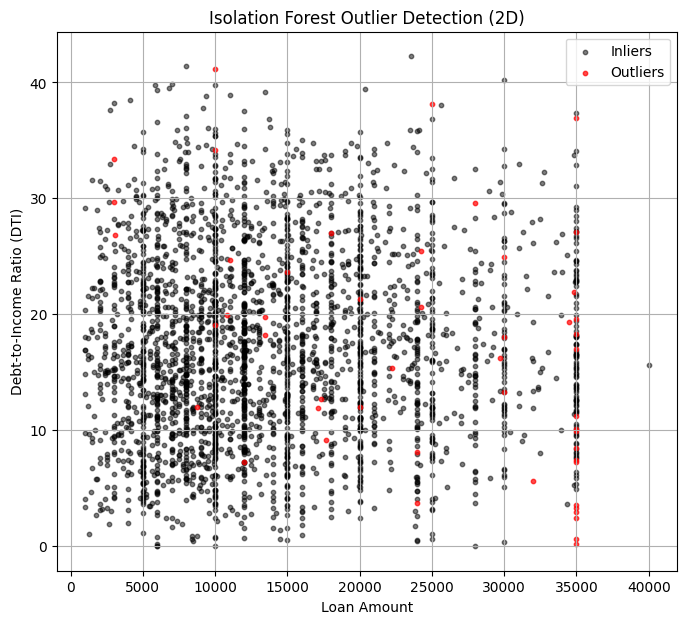

In [12]:
# 대출 규모와 DTI를 이용하여 이상치 시각화
columns = ['loan_amnt', 'dti']
X_viz = X_train[columns].copy()

X_outliers = X_viz.loc[outliers == -1]
X_clean = X_viz.loc[outliers == 1]

# 2D 시각화
X_clean_sample = X_clean.sample(n=3000, random_state=42)
X_outliers_sample = X_outliers.sample(n=50, random_state=42)

plt.figure(figsize=(8, 7))
plt.scatter(X_clean_sample['loan_amnt'], X_clean_sample['dti'],
            c='black', label='Inliers', alpha=0.5, s=10)
plt.scatter(X_outliers_sample['loan_amnt'], X_outliers_sample['dti'],
            c='red', label='Outliers', alpha=0.7, s=10)

plt.xlabel('Loan Amount')
plt.ylabel('Debt-to-Income Ratio (DTI)')
plt.title('Isolation Forest Outlier Detection (2D)')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 TSNE를 이용한 차원 축소 및 이상치 시각화

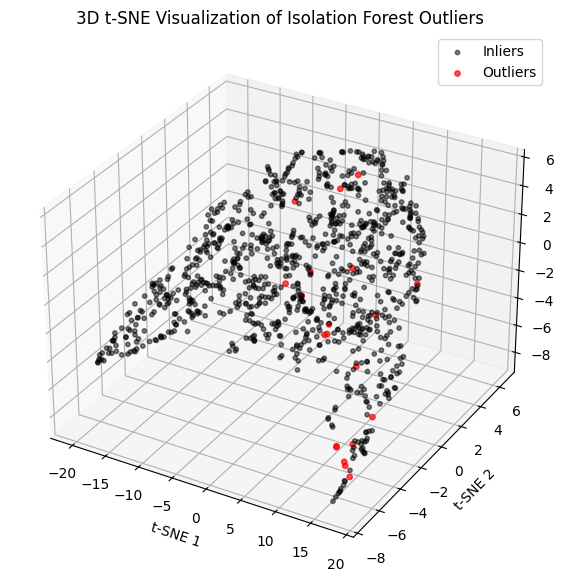

In [13]:
# 4. TSNE를 이용한 이상치 시각화 분석 : 기존 정보로는 시각화 한계가 있어 차원축소 적용
from sklearn.manifold import TSNE
import numpy as np

# 수치형 데이터만 추출(약 1만개)하여 T-SNE로 3차원 축소
X_tsne_input_clean = X_train_numeric[outliers==1].sample(n=1000,random_state=42).select_dtypes(include='number')
X_tsne_input_outliers = X_train_numeric[outliers==-1].sample(n=20,random_state=42).select_dtypes(include='number')
X_tsne_input = pd.concat([X_tsne_input_clean,X_tsne_input_outliers], axis=0)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

# 시각화
labels = np.array([1]*1000 + [-1]*20)
tsne_df = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])
tsne_df['outlier'] = labels

inliers = tsne_df[tsne_df['outlier'] == 1]
outliers_df = tsne_df[tsne_df['outlier'] == -1]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(inliers['x'], inliers['y'], inliers['z'],
           c='black', label='Inliers', alpha=0.5, s=10)
ax.scatter(outliers_df['x'], outliers_df['y'], outliers_df['z'],
           c='red', label='Outliers', alpha=0.7, s=15)

ax.set_title('3D t-SNE Visualization of Isolation Forest Outliers')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.legend()
plt.show()

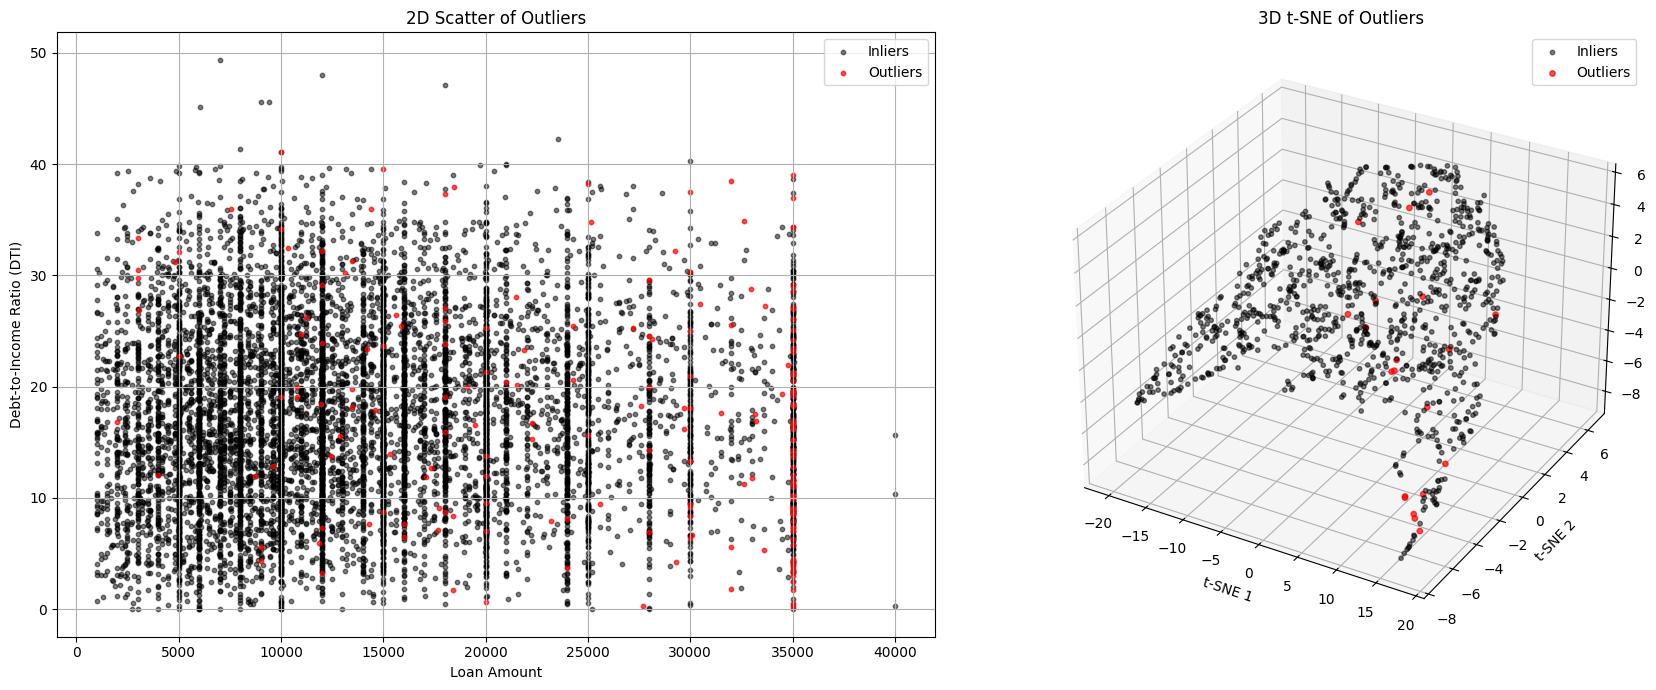

In [14]:
# 병렬 시각화
X_clean_sample = X_clean.sample(n=10000, random_state=42)
X_outliers_sample = X_outliers.sample(n=200, random_state=42)

fig = plt.figure(figsize=(18, 7))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_clean_sample['loan_amnt'], X_clean_sample['dti'],
            c='black', label='Inliers', alpha=0.5, s=10)
ax1.scatter(X_outliers_sample['loan_amnt'], X_outliers_sample['dti'],
            c='red', label='Outliers', alpha=0.7, s=10)
ax1.set_xlabel('Loan Amount')
ax1.set_ylabel('Debt-to-Income Ratio (DTI)')
ax1.set_title('2D Scatter of Outliers')
ax1.legend()
ax1.grid(True)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(tsne_df[tsne_df['outlier'] == 1]['x'],
            tsne_df[tsne_df['outlier'] == 1]['y'],
            tsne_df[tsne_df['outlier'] == 1]['z'],
            c='black', label='Inliers', alpha=0.5, s=10)
ax2.scatter(tsne_df[tsne_df['outlier'] == -1]['x'],
            tsne_df[tsne_df['outlier'] == -1]['y'],
            tsne_df[tsne_df['outlier'] == -1]['z'],
            c='red', label='Outliers', alpha=0.7, s=15)
ax2.set_title('3D t-SNE of Outliers')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Boruta 알고리즘을 활용한 변수선택

In [15]:
# 5. Boruta 알고리즘을 활용한 변수선택 
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# 원핫 인코딩된 변수 식별
onehot_columns = X_train_clean.select_dtypes(include='bool').columns.tolist()

# 수치형 + 라벨 인코딩된 변수 선택
X_boruta = X_train_clean.drop(columns=onehot_columns)
y_boruta = y_train_clean.copy()

# Boruta 알고리즘 적용
rf = RandomForestClassifier(max_depth=5, random_state=42, n_jobs=-1)

np.int = np.int64
np.float = np.float64
np.bool = np.bool_

brtfs = BorutaPy(estimator=rf,n_estimators=7,verbose=1,random_state=42,max_iter=15,alpha=0.01)
brtfs.fit(X_boruta.values, y_boruta.values)

selected_features = X_boruta.columns[brtfs.support_].tolist()    
X_selected = X_boruta[selected_features]
X_onehot = X_train_clean[onehot_columns]
print(f"Number of selected features(Non-onehot): {len(selected_features)}")
print(selected_features)

Iteration: 1 / 15
Iteration: 2 / 15
Iteration: 2 / 15
Iteration: 3 / 15
Iteration: 3 / 15
Iteration: 4 / 15
Iteration: 4 / 15
Iteration: 5 / 15
Iteration: 5 / 15
Iteration: 6 / 15
Iteration: 6 / 15
Iteration: 7 / 15
Iteration: 7 / 15
Iteration: 8 / 15
Iteration: 8 / 15
Iteration: 9 / 15
Iteration: 9 / 15
Iteration: 10 / 15
Iteration: 10 / 15
Iteration: 11 / 15
Iteration: 11 / 15
Iteration: 12 / 15
Iteration: 12 / 15
Iteration: 13 / 15
Iteration: 13 / 15
Iteration: 14 / 15


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	10
Tentative: 	2
Rejected: 	2
Number of selected features(Non-onehot): 10
['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'mort_acc']
Iteration: 14 / 15


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	10
Tentative: 	2
Rejected: 	2
Number of selected features(Non-onehot): 10
['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 

In [16]:
# 최종 훈련데이터 가공 완료
X_train_brtfs = pd.concat([X_selected, X_onehot], axis=1)
X_train_brtfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274448 entries, 214484 to 257563
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            274448 non-null  float64
 1   term                                 274448 non-null  int64  
 2   int_rate                             274448 non-null  float64
 3   installment                          274448 non-null  float64
 4   sub_grade                            274448 non-null  int32  
 5   annual_inc                           274448 non-null  float64
 6   dti                                  274448 non-null  float64
 7   revol_bal                            274448 non-null  float64
 8   revol_util                           274448 non-null  float64
 9   mort_acc                             274448 non-null  float64
 10  home_ownership_OTHER                 274448 non-null  bool   
 11  home_ownershi

## 5. 모델 구축 및 평가

### 5.1 클래스 불균형 문제 및 교차 검증 개선

기존 코드에서는 다음과 같은 문제점이 있었습니다:

1. **검증 무결성 이슈 (Validation Integrity Issue)**: ADASYN으로 생성된 합성 데이터가 교차 검증(CV) 과정에서 훈련 및 검증 폴드에 모두 포함되었습니다.

2. **과대평가된 성능 지표 (Inflated Performance Metrics)**: 검증 세트에 합성 데이터가 포함되면, 모델은 사실상 훈련 데이터의 변형된 버전으로 평가되어 성능이 과대평가됩니다.

3. **과적합 위험 (Overfitting Risk)**: 합성 데이터로 검증하면 모델이 실제 데이터에 대한 일반화 능력 대신 합성 패턴을 학습할 위험이 있습니다.

이러한 문제를 해결하기 위해 **imblearn.pipeline**을 사용하여 교차 검증의 각 폴드 내에서만 오버샘플링이 적용되도록 수정했습니다. 이 방식은:

- 각 CV 폴드의 **훈련 데이터에만** ADASYN이 적용됨
- 검증은 항상 **원본 데이터**로만 수행됨
- 모델의 실제 성능을 더 정확하게 평가할 수 있음

### 5.2 XGBoost 모델 최적화 이단계 접근법

XGBoost 모델의 하이퍼파라미터 튜닝에 이단계 접근법(Two-Step Optimization)을 적용합니다:

**1단계: 초기 하이퍼파라미터 탐색**
- 상대적으로 높은 학습률(0.1)과 고정된 n_estimators 값으로 하이퍼파라미터 조합을 탐색
- 각 하이퍼파라미터 조합이 동일한 학습 기회(같은 트리 개수)를 갖도록 보장
- 교차 검증 내에서 ADASYN 오버샘플링을 정확히 적용

**2단계: 최적 모델 미세 조정**
- 1단계에서 찾은 최적 하이퍼파라미터에 낮은 학습률(0.01)과 높은 n_estimators(10000) 적용
- early_stopping_rounds를 사용하여 최적의 트리 개수 결정
- 전체 훈련 데이터와 검증 데이터를 사용하여 최종 모델 학습

**이러한 접근법의 이점:**
- 공정한 하이퍼파라미터 비교: 1단계에서 모든 조합이 동일한 tree 개수로 평가됨
- 과적합 방지: 낮은 학습률과 early stopping으로 모델 안정성 향상
- 계산 효율성: 미세 조정은 최적 하이퍼파라미터 조합에만 수행

In [17]:
# 1단계: 초기 하이퍼파라미터 탐색 - 높은 학습률로 여러 조합 탐색
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import RandomizedSearchCV
import os
import pickle

# 하이퍼파라미터 검색 결과를 저장할 경로 설정
hp_search_results_path = 'model_results/hp_search_results.pkl'

# 이미 저장된 하이퍼파라미터 결과가 있는지 확인
if os.path.exists(hp_search_results_path):
    print("저장된 하이퍼파라미터 검색 결과를 불러옵니다...")
    with open(hp_search_results_path, 'rb') as f:
        step1_search = pickle.load(f)
    
    print("최적 하이퍼파라미터:")
    print(step1_search.best_params_)
    print("최고 F1 점수 (CV):", step1_search.best_score_)
    
    # 상위 5개 하이퍼파라미터 조합 확인
    step1_results = pd.DataFrame(step1_search.cv_results_)
    columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    top_5_params = step1_results[columns].sort_values('rank_test_score').head(5)
    print("\n상위 5개 하이퍼파라미터 조합:")
    print(top_5_params)
else:
    # ADASYN을 파이프라인 내에서 적용하여 교차 검증 시 검증 데이터 무결성 유지
    step1_pipeline = ImbPipeline([
        ('sampler', ADASYN(random_state=42)),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42, learning_rate=0.1))
    ])
    
    # 하이퍼파라미터 설정 - 고정된 n_estimators로 공정한 비교 보장
    param_dist = {
        'classifier__n_estimators': [100, 300, 500],  # 고정된 값으로 탐색
        'classifier__max_depth': [3, 5, 7, 9],
        'classifier__min_child_weight': [0, 0.1, 0.3, 0.5],
        'classifier__gamma': [0, 0.1, 1],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__reg_alpha': [0, 0.1, 1],
        'classifier__reg_lambda': [1, 5, 10]
    }
    
    # RandomizedSearchCV - 각 CV 폴드 내에서 올바르게 ADASYN 적용
    step1_search = RandomizedSearchCV(
        estimator=step1_pipeline,
        param_distributions=param_dist,
        n_iter=25,  # 계산 자원에 따라 조정 가능
        scoring='f1',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # 1단계 모델 훈련
    print("1단계: 초기 하이퍼파라미터 탐색 중...")
    step1_search.fit(X_train_brtfs, y_train_clean)
    
    # 최적 하이퍼파라미터 출력
    print("최적 하이퍼파라미터:")
    print(step1_search.best_params_)
    print("최고 F1 점수 (CV):", step1_search.best_score_)
    
    # 상위 5개 하이퍼파라미터 조합 확인
    step1_results = pd.DataFrame(step1_search.cv_results_)
    columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    top_5_params = step1_results[columns].sort_values('rank_test_score').head(5)
    print("\n상위 5개 하이퍼파라미터 조합:")
    print(top_5_params)
    
    # 하이퍼파라미터 검색 결과 저장
    print("\n하이퍼파라미터 검색 결과를 저장합니다...")
    with open(hp_search_results_path, 'wb') as f:
        pickle.dump(step1_search, f)

1단계: 초기 하이퍼파라미터 탐색 중...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
최적 하이퍼파라미터:
{'classifier__subsample': 1.0, 'classifier__reg_lambda': 5, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 0.1, 'classifier__max_depth': 7, 'classifier__gamma': 1, 'classifier__colsample_bytree': 1.0}
최고 F1 점수 (CV): 0.9354467284124377

상위 5개 하이퍼파라미터 조합:
                                               params  mean_test_score  \
12  {'classifier__subsample': 1.0, 'classifier__re...         0.935447   
16  {'classifier__subsample': 1.0, 'classifier__re...         0.935357   
2   {'classifier__subsample': 1.0, 'classifier__re...         0.935325   
19  {'classifier__subsample': 0.8, 'classifier__re...         0.935320   
4   {'classifier__subsample': 0.8, 'classifier__re...         0.935289   

    std_test_score  rank_test_score  
12        0.000453                1  
16        0.000471                2  
2         0.000426                3  
19  

### 5.3 최적 모델 미세 조정 및 성능 평가

이제 1단계에서 찾은 최적 하이퍼파라미터를 바탕으로 학습률을 낮추고(0.01), 트리 개수를 늘려(10000) 조기 중단(early stopping)을 적용하여 최종 모델을 학습합니다.
이 접근법은 모델이 천천히 학습하면서 최적 지점에서 멈출 수 있게 합니다.


2단계: 최적 모델 미세 조정 중...
[0]	validation_0-logloss:0.68664	validation_1-logloss:0.67796
[1]	validation_0-logloss:0.68040	validation_1-logloss:0.67275
[0]	validation_0-logloss:0.68664	validation_1-logloss:0.67796
[1]	validation_0-logloss:0.68040	validation_1-logloss:0.67275
[2]	validation_0-logloss:0.67427	validation_1-logloss:0.66763
[2]	validation_0-logloss:0.67427	validation_1-logloss:0.66763
[3]	validation_0-logloss:0.66826	validation_1-logloss:0.66263
[4]	validation_0-logloss:0.66236	validation_1-logloss:0.65770
[3]	validation_0-logloss:0.66826	validation_1-logloss:0.66263
[4]	validation_0-logloss:0.66236	validation_1-logloss:0.65770
[5]	validation_0-logloss:0.65658	validation_1-logloss:0.65280
[6]	validation_0-logloss:0.65089	validation_1-logloss:0.64804
[5]	validation_0-logloss:0.65658	validation_1-logloss:0.65280
[6]	validation_0-logloss:0.65089	validation_1-logloss:0.64804
[7]	validation_0-logloss:0.64530	validation_1-logloss:0.64337
[8]	validation_0-logloss:0.63981	validation_1-l

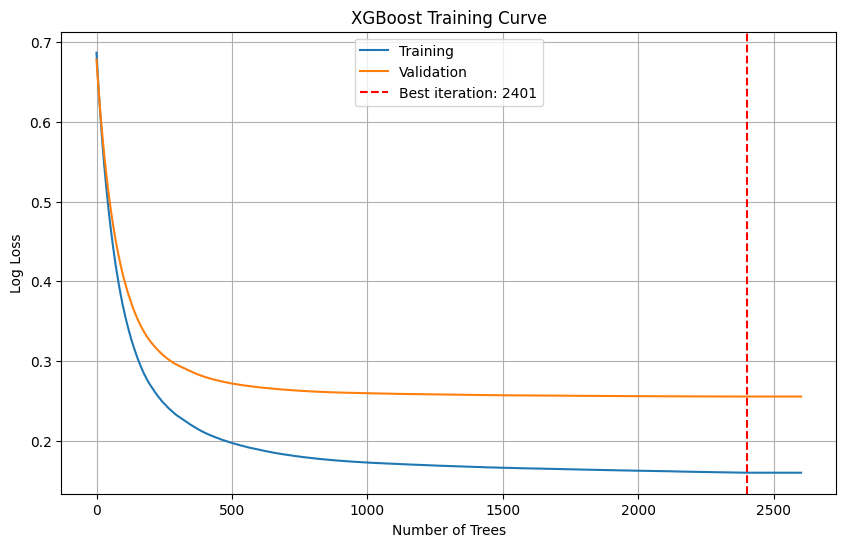

In [18]:
# 2단계: 최적 모델 미세 조정 - 낮은 학습률, 높은 n_estimators, early stopping

# 최종 모델 파일 경로
final_model_path = 'model_results/final_model.pkl'

# 1단계에서 찾은 최적 하이퍼파라미터 가져오기
best_params = step1_search.best_params_

# 테스트 데이터 준비
X_test_brtfs = X_test[selected_features + onehot_columns].copy()

# 검증용 데이터셋 분할 (원본 데이터에서 10%를 검증에 사용)
from sklearn.model_selection import train_test_split
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_brtfs, y_train_clean, test_size=0.1, random_state=42, stratify=y_train_clean
)

# 이미 학습된 최종 모델이 있는지 확인
if os.path.exists(final_model_path):
    print("저장된 최종 모델을 불러옵니다...")
    with open(final_model_path, 'rb') as f:
        final_model = pickle.load(f)
        # 저장된 평가 결과 불러오기
    evals_result_path = 'model_results/evals_result.pkl'
    if os.path.exists(evals_result_path):
        with open(evals_result_path, 'rb') as f:
            evals_result = pickle.load(f)
    # 최적 트리 개수 확인 (XGBoost 버전에 따라 속성 이름이 다를 수 있음)
    best_iteration = final_model.best_iteration if hasattr(final_model, 'best_iteration') else None
    print(f"최적 트리 개수: {best_iteration}")
else:
    # ADASYN 적용 (최종 훈련 데이터에만)
    adasyn = ADASYN(random_state=42)
    X_train_final_resampled, y_train_final_resampled = adasyn.fit_resample(X_train_final, y_train_final)
    
    # 최종 모델 생성 - 낮은 학습률, 높은 n_estimators, early stopping 적용
    final_model = XGBClassifier(
        # 1단계에서 찾은 최적 하이퍼파라미터 적용
        max_depth=int(best_params['classifier__max_depth']),
        min_child_weight=best_params['classifier__min_child_weight'],
        gamma=best_params['classifier__gamma'],
        subsample=best_params['classifier__subsample'],
        colsample_bytree=best_params['classifier__colsample_bytree'],
        reg_alpha=best_params['classifier__reg_alpha'],
        reg_lambda=best_params['classifier__reg_lambda'],
        # 미세 조정을 위한 파라미터
        learning_rate=0.01,           # 낮은 학습률
        n_estimators=10000,           # 많은 트리 개수
        early_stopping_rounds=200,    # 조기 중단
        eval_metric='logloss',        # 평가 지표
        random_state=42,
        verbosity=1
    )
    
    # 최종 모델 훈련 - 검증 데이터로 early stopping 모니터링
    print("\n2단계: 최적 모델 미세 조정 중...")
    final_model.fit(
        X_train_final_resampled, y_train_final_resampled,
        eval_set=[(X_train_final_resampled, y_train_final_resampled), 
                  (X_val_final, y_val_final)],
        verbose=True
    )
    
    # 학습 결과 및 모델 저장
    with open(final_model_path, 'wb') as f:
        pickle.dump(final_model, f)
    
    # 평가 결과 저장
    evals_result = final_model.evals_result()
    with open('model_results/evals_result.pkl', 'wb') as f:
        pickle.dump(evals_result, f)

# 최적 트리 개수 확인 (XGBoost 버전에 따라 속성 이름이 다를 수 있음)
best_iteration = final_model.best_iteration if hasattr(final_model, 'best_iteration') else None
print(f"최적 트리 개수: {best_iteration}")

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_0']['logloss'], label='Training')
plt.plot(evals_result['validation_1']['logloss'], label='Validation')
plt.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best iteration: {best_iteration}')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Training Curve')
plt.legend()
plt.grid(True)
plt.show()

# 테스트 데이터에 대한 예측
y_pred_best = final_model.predict(X_test_brtfs)
y_proba_best = final_model.predict_proba(X_test_brtfs)[:, 1]

### 5.4 최종 모델 성능 평가

In [19]:
# 평가 지표 출력
print("\n<< 최종 XGBoost 모델 성능 >>")
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))
print("\n분류 보고서:")
print(classification_report(y_test, y_pred_best))


<< 최종 XGBoost 모델 성능 >>
F1 Score: 0.9354695016927006
ROC AUC: 0.9081721627857662

분류 보고서:
              precision    recall  f1-score   support

           0       0.92      0.48      0.63     23302
           1       0.89      0.99      0.94     95507

    accuracy                           0.89    118809
   macro avg       0.90      0.74      0.78    118809
weighted avg       0.89      0.89      0.88    118809



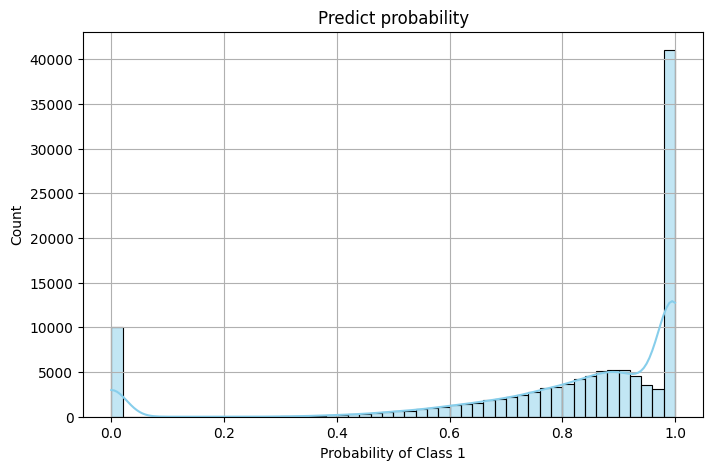

In [20]:
# 예측 확률 시각화
plt.figure(figsize=(8, 5))
sns.histplot(y_proba_best, bins=50, kde=True, color='skyblue')
plt.title("Predict probability")
plt.xlabel("Probability of Class 1")
plt.ylabel("Count")
plt.grid(True)
plt.show()

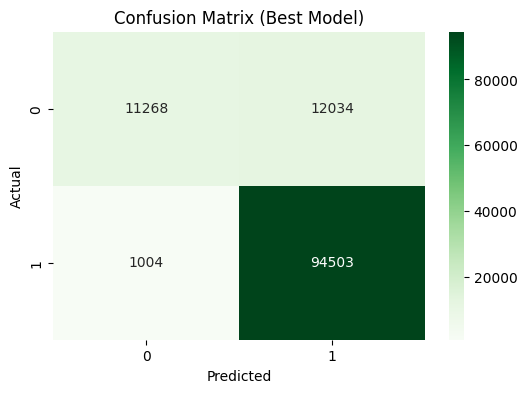

In [21]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

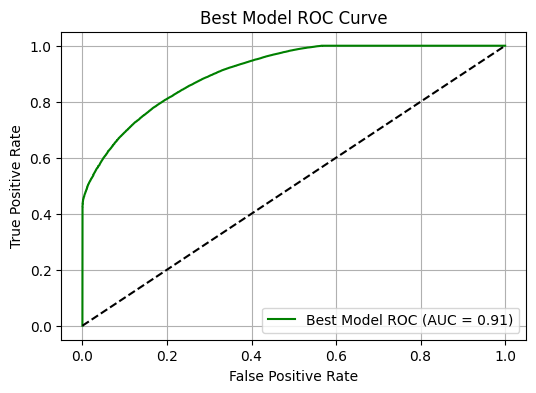

In [22]:
# ROC Curve
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6,4))
plt.plot(fpr_best, tpr_best, label=f'Best Model ROC (AUC = {roc_auc_score(y_test, y_proba_best):.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## 6. 변수 중요도 분석

### 6.1 XGBoost 변수 중요도

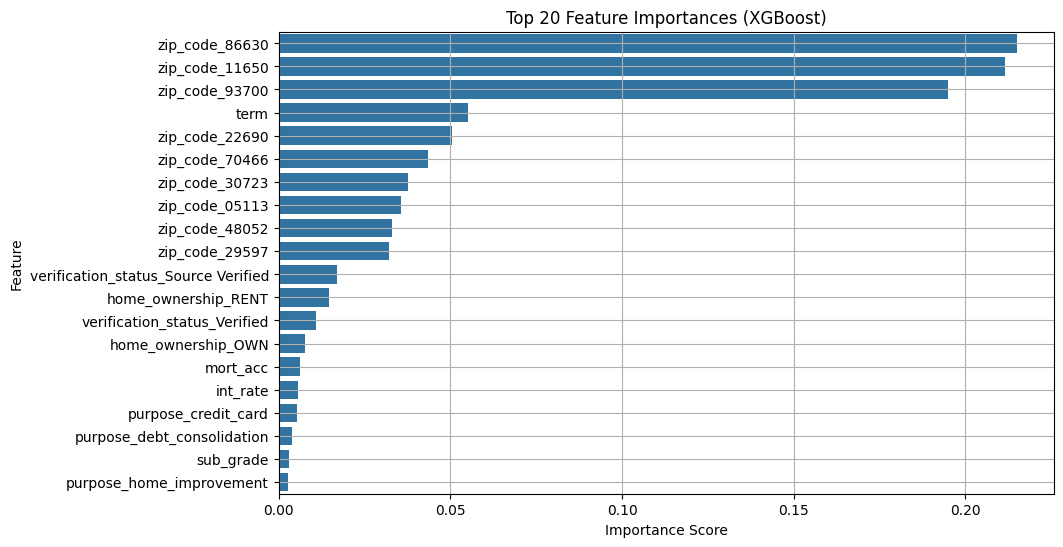

In [23]:
# 상위 20개 feature importance
importances = final_model.feature_importances_
features = X_test_brtfs.columns

top_idx = importances.argsort()[::-1][:20]
top_features = features[top_idx]
top_importances = importances[top_idx]

plt.figure(figsize=(10,6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

XGBoost의 기본 변수 중요도는 모델 전체에서 각 특성이 얼마나 자주 사용되었는지를 보여줍니다.
그러나 이는 **개별 예측에 대한 특성 기여도**를 파악하기 어렵다는 한계가 있습니다.

이제 **SHAP(SHapley Additive exPlanations)** 분석을 통해 더 깊이 있는 모델 해석을 진행합니다.
SHAP는 게임 이론의 Shapley 값에 기반하여 각 예측에 대한 특성별 기여도를 계산합니다.
이를 통해 모델이 **개별 사례별로** 어떤 특성을 중요하게 고려했는지 파악할 수 있습니다.

### 6.2 SHAP를 활용한 모델 해석

In [24]:
# SHAP 패키지 설치 및 임포트
import shap

# SHAP TreeExplainer 생성
explainer = shap.TreeExplainer(final_model)

# 훈련 데이터의 일부 샘플에 대한 SHAP 값 계산 (전체 데이터셋은 메모리 이슈가 있을 수 있음)
X_train_sample = X_train_brtfs.sample(n=1000, random_state=42)
shap_values = explainer.shap_values(X_train_sample)

# 기대값 출력 (모델의 기본 예측값)
print("모델의 기본 예측값 (base value):", explainer.expected_value)

f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


모델의 기본 예측값 (base value): 0.030521773


### 6.3 개별 대출 사례에 대한 SHAP 분석

In [25]:
# 특정 샘플 예측에 대한 SHAP 값 분석
# 부도 사례와 정상 상환 사례 각각 하나씩 선택
loan_idx_default = X_train_sample.index[y_train[X_train_sample.index] == 1][0]  # 부도 사례
loan_idx_paid = X_train_sample.index[y_train[X_train_sample.index] == 0][0]     # 정상 상환 사례

# 선택된 대출 사례의 특성 값 출력
print("부도 대출 사례 특성:")
print(X_train_brtfs.loc[loan_idx_default, :].head(10))
print("\n정상 상환 대출 사례 특성:")
print(X_train_brtfs.loc[loan_idx_paid, :].head(10))

# 실제 클래스 확인
print("\n부도 사례 실제 클래스:", y_train.loc[loan_idx_default])
print("정상 상환 사례 실제 클래스:", y_train.loc[loan_idx_paid])

# 예측 확률 확인
print("\n부도 사례 예측 확률:", final_model.predict_proba(X_train_brtfs.loc[loan_idx_default:loan_idx_default, :])[0][1])
print("정상 상환 사례 예측 확률:", final_model.predict_proba(X_train_brtfs.loc[loan_idx_paid:loan_idx_paid, :])[0][1])

부도 대출 사례 특성:
loan_amnt       8075.0
term                36
int_rate         17.57
installment      290.2
sub_grade           16
annual_inc     30000.0
dti               23.2
revol_bal       4103.0
revol_util        80.5
mort_acc           5.0
Name: 96288, dtype: object

정상 상환 대출 사례 특성:
loan_amnt       6000.0
term                36
int_rate         16.29
installment     211.81
sub_grade           16
annual_inc     40404.0
dti              13.72
revol_bal       4770.0
revol_util        58.2
mort_acc           0.0
Name: 44427, dtype: object

부도 사례 실제 클래스: 1
정상 상환 사례 실제 클래스: 0

부도 사례 예측 확률: 0.9998288
정상 상환 사례 예측 확률: 0.00026364822


아래의 SHAP Force Plot은 개별 대출 사례에 대한 모델의 예측을 설명합니다:

- **빨간색** 특성은 부도 확률을 **증가**시키는 요인
- **파란색** 특성은 부도 확률을 **감소**시키는 요인
- 각 특성의 **너비**는 그 영향력의 **크기**를 나타냄
- **base value**는 데이터셋 전체의 평균 예측값
- **output value**는 해당 사례의 최종 예측값

C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:9: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:9: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:9: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:9: UserWarning: Glyph 47168 (\N{HANGUL SYLLABLE RYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1600x500 with 0 Axes>

f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47168 (\N{HANGUL SYLLABLE RYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Deja

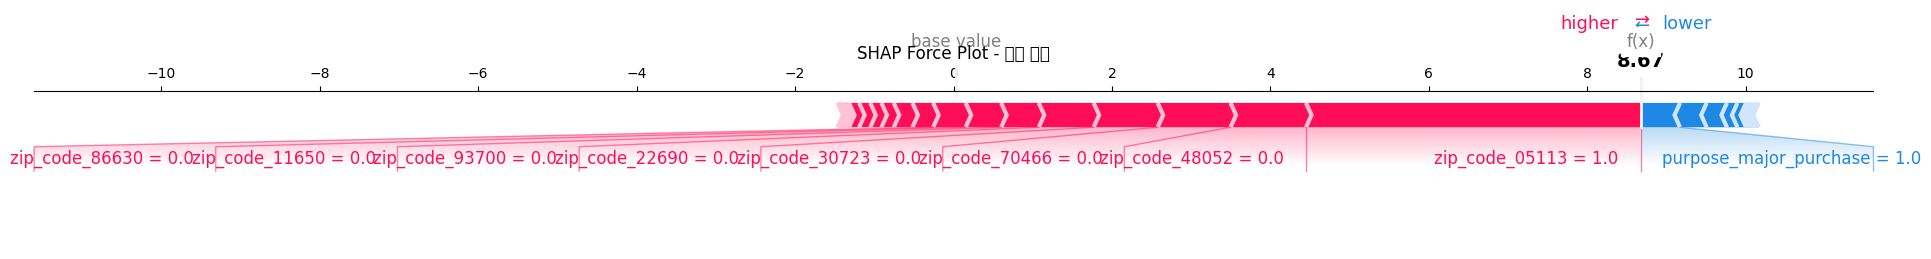

C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:20: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:20: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:20: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:20: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2273109711.py:20: UserWarning: Glyph 47168 (\N{HANGUL SYLLABLE RYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1600x500 with 0 Axes>

f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


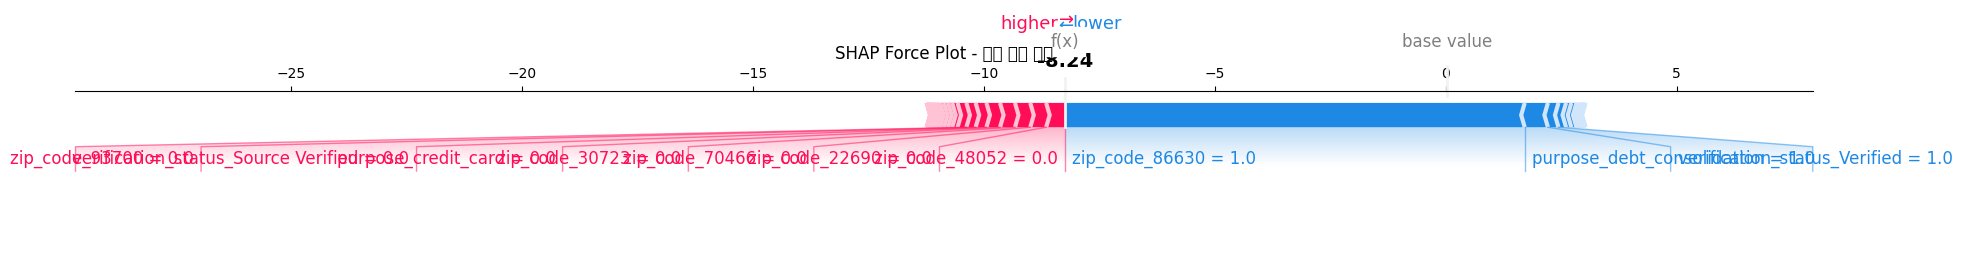

In [26]:
# SHAP Force Plot - 부도 사례
plt.figure(figsize=(16, 5))
shap_idx_default = np.where(np.array(X_train_sample.index) == loan_idx_default)[0][0]
shap.force_plot(explainer.expected_value, 
                shap_values[shap_idx_default, :],
                X_train_sample.iloc[shap_idx_default, :],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot - 부도 사례")
plt.tight_layout()
plt.show()

# SHAP Force Plot - 정상 상환 사례
plt.figure(figsize=(16, 5))
shap_idx_paid = np.where(np.array(X_train_sample.index) == loan_idx_paid)[0][0]
shap.force_plot(explainer.expected_value, 
                shap_values[shap_idx_paid, :],
                X_train_sample.iloc[shap_idx_paid, :],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot - 정상 상환 사례")
plt.tight_layout()
plt.show()

### 6.4 SHAP 글로벌 분석 - 전체 특성 중요도

C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\3278392793.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False)


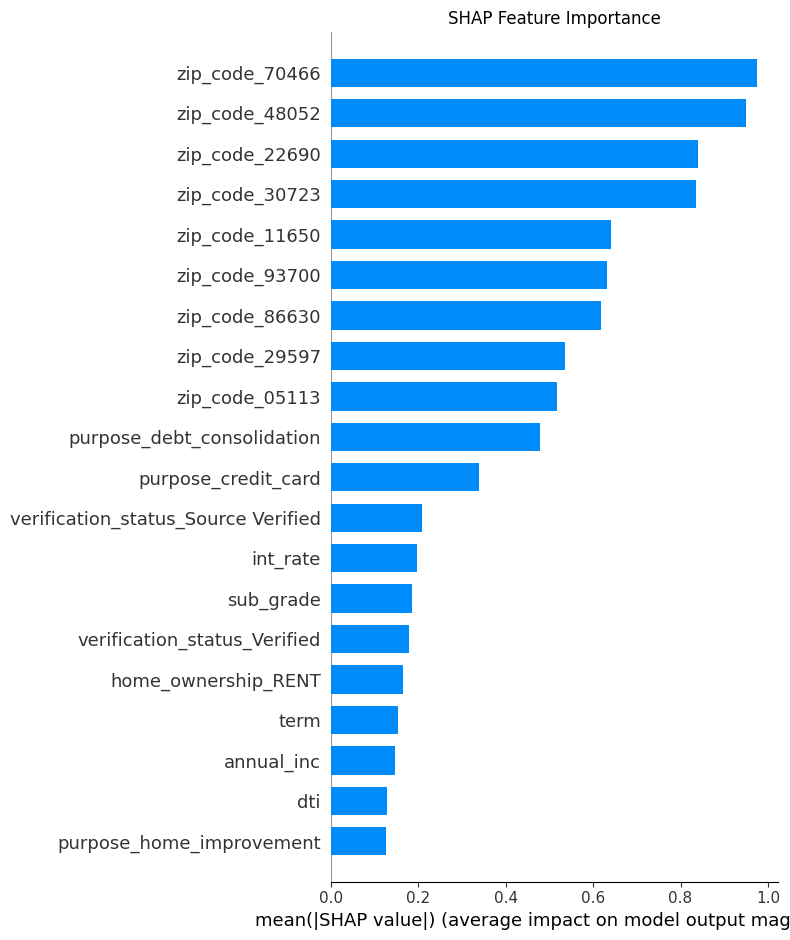

In [27]:
# SHAP Summary Plot - 모든 특성의 영향력 시각화
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

C:\Users\chlje\AppData\Local\Temp\ipykernel_12008\2232339633.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_sample, show=False)


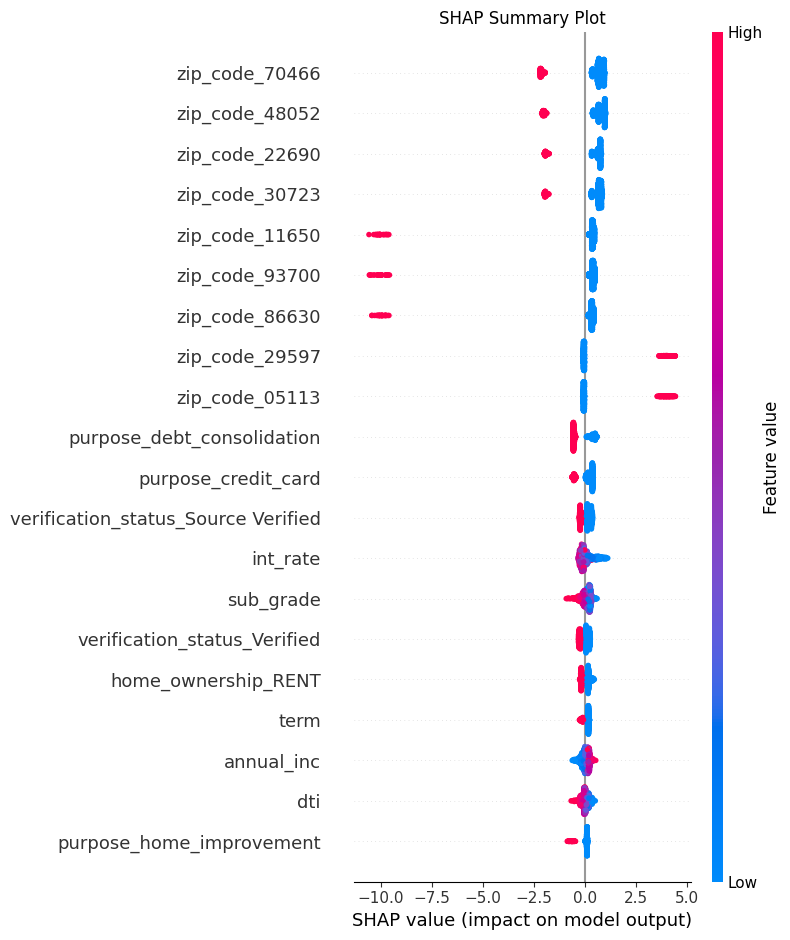

In [28]:
# SHAP Summary Plot - 각 특성값에 따른 영향력 변화 시각화
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sample, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

SHAP 요약 플롯의 해석:

1. **Feature Importance**:
   - 막대 그래프는 각 특성의 평균 절대 SHAP 값 기준 중요도를 보여줍니다.
   - XGBoost의 기본 feature_importance와 달리 각 예측에 대한 기여도의 평균입니다.

2. **Summary Plot**:
   - 각 점은 하나의 샘플에 대한 하나의 특성 값을 나타냅니다.
   - 색상: 특성 값이 **높을수록 빨간색**, **낮을수록 파란색**
   - 수평 위치: SHAP 값으로, **오른쪽**은 부도 확률을 **증가**시키고, **왼쪽**은 **감소**시킴
   - 이를 통해 특성 값의 변화에 따른 모델 예측 영향을 파악할 수 있습니다.

예를 들어, 일부 특성들은 값이 증가할수록 부도 확률이 높아지는 반면(빨간 점이 오른쪽에 위치), 
다른 특성들은 값이 낮을수록 부도 확률이 높아집니다(파란 점이 오른쪽에 위치).

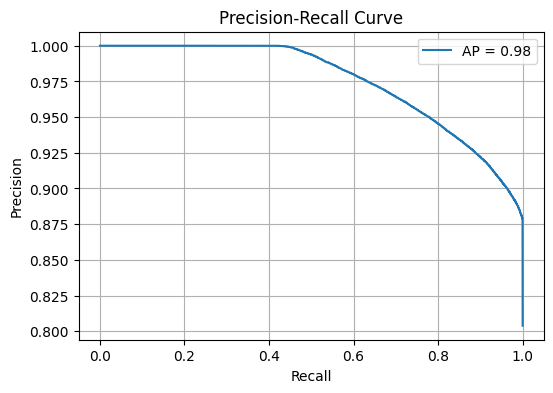

In [29]:
# precision recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
avg_precision = average_precision_score(y_test, y_proba_best)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

## 7. 결론

본 분석에서는 XGBoost 알고리즘을 사용하여 은행 대출의 부도 여부를 예측하는 모델을 구축했습니다. 주요 결론은 다음과 같습니다:

1. **데이터 전처리**: 결측치 처리, 이상치 제거, Boruta 알고리즘을 통한 변수 선택을 수행하여 모델의 기반을 마련했습니다.

2. **클래스 불균형 처리**: 계층적 샘플링으로 훈련/테스트 세트의 클래스 분포를 유지하고, ADASYN 알고리즘을 교차 검증 내에서 올바르게 적용하여 소수 클래스에 대한 예측 성능을 개선했습니다.

3. **이단계 최적화 접근법**: 
   - 초기 하이퍼파라미터 탐색 단계에서는 고정된 n_estimators로 공정한 비교를 수행
   - 최종 모델 구축 단계에서는 낮은 학습률과 early stopping을 적용하여 최적의 트리 개수를 찾음

4. **모델 해석**: 
   - XGBoost 변수 중요도를 통해 주요 특성들을 식별
   - SHAP 분석을 통해 개별 대출 사례에 대한 예측 근거를 파악하고, 특성값 변화에 따른 예측 영향을 이해

5. **성능 평가**: F1 점수, ROC-AUC, 정밀도-재현율 곡선 등 다양한 지표를 통해 모델의 성능을 종합적으로 평가했습니다.

이러한 접근법은 단순히 높은 예측 정확도를 달성하는 것을 넘어, 모델의 예측 결정을 이해하고 설명할 수 있는 프레임워크를 제공합니다.